In [1]:
#from magnum import *
from math import *
import numpy as np
import random
import os.path
import os
import time
import matplotlib.pyplot as plt
import matplotlib
from platform import python_version
import discretisedfield as df
import discretisedfield.tools as dft
import glob
import natsort
import tqdm
print(python_version())
%matplotlib inline

3.8.13


In [2]:
#only weight the topolgocial density around r/4 of peak vortex magnetization 
def get_weight_matrix(mag, mode="cutoff"):
    
    magz = mag[:,:,0,2]
    magz = np.abs(magz)

    index = np.argmax(magz)
    mulind = np.argpartition(np.ravel(magz), -4)[-4:]

    coo = np.unravel_index(index, magz.shape)
    mulcoox, mulcooy = np.unravel_index(mulind, magz.shape)

    weights = np.array([magz[mulcoox[0], mulcooy[0]], magz[mulcoox[1], mulcooy[1]], magz[mulcoox[2], mulcooy[2]], magz[mulcoox[3], mulcooy[3]]])

    finalx = np.ma.average(mulcoox, weights=weights)
    finaly = np.ma.average(mulcooy, weights=weights)
    
    weightmatrix = np.ones(magz.shape)
    distmatrix = np.ones(magz.shape)
    
    for i in range(magz.shape[0]):
        for j in range(magz.shape[1]):
            if i ==finalx and j == finaly:
                distmatrix[i,j] = 0.0
            else:
                distmatrix[i,j]= np.sqrt((i-finalx)**2+(j-finaly)**2)                

    cutoff=round(25/200*mag.shape[0])

    for i in range(magz.shape[0]):
        for j in range(magz.shape[1]):
            if distmatrix[i,j]>=cutoff:
                    weightmatrix[i,j] =0.0
            else:
                    weightmatrix[i,j] = 1.0            


    return weightmatrix.reshape(magz.shape[0], magz.shape[1], 1, 1)

In [3]:
def get_trajectory_vortex(filelist, z_slice= 0, plot=False, prints=False):
    num_files = len(filelist)
    #print(num_files, " files are to analysed")
    traj = np.zeros((num_files,2))
    count = 0
    for file in tqdm.tqdm(filelist):
        
        field_read = df.Field.fromfile(file) 
        #print(field_read.mesh.n)
        subregion = df.Region(p1=(0.0, 0.0, (z_slice)*field_read.mesh.dz), p2=(field_read.mesh.n[0]*field_read.mesh.dx, field_read.mesh.n[1]*field_read.mesh.dy, (z_slice+1)*field_read.mesh.dz))
        m = field_read[subregion]
        if plot:
            m.orientation.plane("z").mpl()
            plt.show()
        #coordinatefield = mag.coordinate_field
        q = dft.topological_charge_density(m.orientation.plane("z"), method="berg-luescher")

        x = df.Field(m.mesh, dim=1, value=lambda p: p[0])  # p[1] -> y, p[2] -> z
        y = df.Field(m.mesh, dim=1, value=lambda p: p[1])  # p[1] -> y, p[2] -> z
        
        #weight matrix to cut-off outer areas and spin canting at the edges of the vortex
        wm = get_weight_matrix(m.array, mode="4w-cutoff")
       

        rx = df.integral(x.plane("z") *  q * wm* df.dx*df.dy)
        ry = df.integral(y.plane("z") *  q * wm* df.dx*df.dy) 

        rn =  df.integral(q* wm*df.dx*df.dy)

        rx = rx/rn*1e9
        ry = ry/rn*1e9    
        
        traj[count, 0] = rx
        traj[count,1] = ry
        count+=1
        #to plot the evaluated region:
        if plot:
            qwm = q*wm
            qwm.mpl()
            plt.scatter(rx, ry)
            plt.show()
        if prints:
            print("rx, ry:", rx, ry)
    return traj


In [203]:
##Track MM CV first 
#in the paper we used to HB model to track the CV. However, to make the repository more lightweight we track here only coarse 
# discretizations. 
# For the CV we also only track the top layer here as we assume the vortex to be uniform along the z-axis.
# However, you are welcome to simulate all necessary data with this repository.
nt= 20
filelist = glob.glob("CV/MM_cylindrical/IP_dynamics_"+str(nt)+"/*.omf")
filelist = natsort.natsorted(filelist)
#check the bottom slice of the vortex. You have to loop over all slices here if you want to repeat the original study
CV_traj = get_trajectory_vortex(filelist, z_slice=0)

filelist = glob.glob("BV/MM_cylindrical/IP_dynamics_"+str(nt)+"/*.omf")
filelist = natsort.natsorted(filelist)
BV_traj = get_trajectory_vortex(filelist, z_slice=0)
BV_traj_top = get_trajectory_vortex(filelist, z_slice=nt-1)

filelist = glob.glob("BP/MM_cylindrical/IP_dynamics_"+str(nt)+"/*.omf")
filelist = natsort.natsorted(filelist)
BPV_traj_bottom = get_trajectory_vortex(filelist, z_slice=0)
BPV_traj_top = get_trajectory_vortex(filelist, z_slice=nt-1)
BP_traj_bottom = get_trajectory_vortex(filelist, z_slice=int(round(nt*0.6))-1)
BP_traj_top = get_trajectory_vortex(filelist, z_slice=int(round(nt*0.6)))
BP_traj = (BP_traj_bottom+BP_traj_top)/2  #BP position is mean of the two neighbored vorex positions with opposite polarity - at layer interface

100%|███████████████████████████████████████████| 43/43 [01:09<00:00,  1.61s/it]


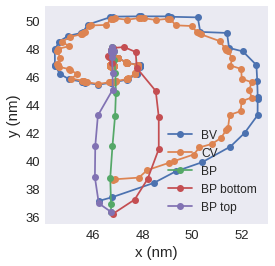

In [206]:
## Similar to Figure 6 a/b in the main paper 
## 
plt.figure(figsize=(4,4))
plt.plot(BV_traj[:,0], BV_traj[:,1], "o-", label = "BV")
plt.plot(CV_traj[:,0], CV_traj[:,1], "o-", label = "CV")
plt.plot(BP_traj[:,0], BP_traj[:,1], "o-", label = "BP")
plt.plot(BPV_traj_bottom[:,0], BPV_traj_bottom[:,1], "o-", label = "BP bottom")
plt.plot(BPV_traj_top[:,0], BPV_traj_top[:,1], "o-", label = "BP top")
#plt.plot(BV_traj[:,0], BV_traj[:,1], "x-", label = "BV_top")
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.legend()
plt.savefig("Figures/Fig_6b_track.svg", dpi=300, bbox_inches="tight")
plt.show()

In [4]:
def get_cum_dist(traj):
    cum_dist = np.zeros(traj.shape[0], dtype = float)
    cum_dist[0] = 0.0
    for i in range(1, traj.shape[0]):
        traveled_dist =  np.sqrt((traj[i,0]-traj[i-1,0])**2+(traj[i,1]-traj[i-1,1])**2)
        cum_dist[i] = cum_dist[i-1]+traveled_dist
    return cum_dist

In [216]:
##cumulative distance, similar to Figure 6c
cum_dist_BP = get_cum_dist(BP_traj)
cum_dist_BPV_top = get_cum_dist(BPV_traj_top)
cum_dist_BPV_bottom = get_cum_dist(BPV_traj_bottom)
cum_dist_BV = get_cum_dist(BV_traj)
cum_dist_CV = get_cum_dist(CV_traj)


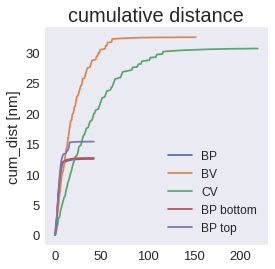

In [225]:
## Similar to Figure 6 c in the main paper 
## The data in the paper is run with a finer discretization
plt.figure(figsize=(4,4))
plt.title("cumulative distance")
plt.plot(cum_dist_BP, "-",label = "BP")
plt.plot(cum_dist_BV, "-", label = "BV")
plt.plot(cum_dist_CV, "-", label = "CV")

plt.plot(cum_dist_BPV_top, "-", label = "BPV bottom")
plt.plot(cum_dist_BPV_bottom, "-", label = "BPV top")

plt.ylabel("time [20 ps]")
plt.ylabel("cum_dist [nm]")
plt.legend()
plt.savefig("Figures/Fig_6c_cumulative_distance.svg", dpi=400, bbox_inches="tight")
plt.show()

In [193]:
# compare discretizations
#
#if False:
nt = 10
filelist_10 = glob.glob("BP/MM_cylindrical/IP_dynamics_10/*.omf")
filelist_10 = natsort.natsorted(filelist_10)
BP_traj_bottom_10 = get_trajectory_vortex(filelist_10, z_slice=int(round(nt*0.6))-1)
BP_traj_top_10 = get_trajectory_vortex(filelist_10, z_slice=int(round(nt*0.6)))
BP_traj_10 = (BP_traj_bottom_10+BP_traj_top_10)/2  #BP position is mean of the two neighbored vorex positions with opposite polarity - at layer interface

nt = 20
filelist_20 = glob.glob("BP/MM_cylindrical/IP_dynamics_20/*.omf")
filelist_20 = natsort.natsorted(filelist_20)
BP_traj_bottom_20 = get_trajectory_vortex(filelist_20, z_slice=int(round(nt*0.6))-1, plot=False, prints = False)
BP_traj_top_20 = get_trajectory_vortex(filelist_20, z_slice=int(round(nt*0.6)), plot=False, prints=False)
BP_traj_20 = (BP_traj_bottom_20+BP_traj_top_20)/2  #BP position is mean of the two neighbored vorex positions with opposite polarity - at layer interface

nt=30
filelist_30 = glob.glob("BP/MM_cylindrical/IP_dynamics_30/*.omf")
filelist_30 = natsort.natsorted(filelist_30)
BP_traj_bottom_30 = get_trajectory_vortex(filelist_30, z_slice=int(round(nt*0.6))-1)
BP_traj_top_30 = get_trajectory_vortex(filelist_30, z_slice=int(round(nt*0.6)))
BP_traj_30 = (BP_traj_bottom_30+BP_traj_top_30)/2  #BP position is mean of the two neighbored vorex positions with opposite polarity - at layer interface

nt=40
filelist_40 = glob.glob("BP/MM_cylindrical/IP_dynamics_40/*.omf")
filelist_40 = natsort.natsorted(filelist_40)
BP_traj_bottom_40 = get_trajectory_vortex(filelist_40, z_slice=int(round(nt*0.6))-1)
BP_traj_top_40 = get_trajectory_vortex(filelist_40, z_slice=int(round(nt*0.6)))
BP_traj_40 = (BP_traj_bottom_40+BP_traj_top_40)/2  #BP position is mean of the two neighbored vorex positions with opposite polarity - at layer interface

nt=50
filelist_50 = glob.glob("BP/MM_cylindrical/IP_dynamics_50/*.omf")
filelist_50 = natsort.natsorted(filelist_50)
BP_traj_bottom_50 = get_trajectory_vortex(filelist_50, z_slice=int(round(nt*0.6))-1)
BP_traj_top_50 = get_trajectory_vortex(filelist_50, z_slice=int(round(nt*0.6)))
BP_traj_50 = (BP_traj_bottom_50+BP_traj_top_50)/2  #BP position is mean of the two neighbored vorex positions with opposite polarity - at layer interface



47  files are to analysed


100%|███████████████████████████████████████████| 47/47 [00:20<00:00,  2.27it/s]


47  files are to analysed


100%|███████████████████████████████████████████| 47/47 [00:16<00:00,  2.78it/s]


43  files are to analysed


100%|███████████████████████████████████████████| 43/43 [01:16<00:00,  1.77s/it]


43  files are to analysed


100%|███████████████████████████████████████████| 43/43 [01:08<00:00,  1.60s/it]


40  files are to analysed


100%|███████████████████████████████████████████| 40/40 [02:42<00:00,  4.06s/it]


40  files are to analysed


100%|███████████████████████████████████████████| 40/40 [02:11<00:00,  3.29s/it]


38  files are to analysed


100%|███████████████████████████████████████████| 38/38 [07:20<00:00, 11.59s/it]


38  files are to analysed


100%|███████████████████████████████████████████| 38/38 [05:57<00:00,  9.40s/it]


38  files are to analysed


100%|███████████████████████████████████████████| 38/38 [07:21<00:00, 11.63s/it]


38  files are to analysed


100%|███████████████████████████████████████████| 38/38 [05:55<00:00,  9.36s/it]


In [199]:
nt=40
filelist_40 = glob.glob("BP/MM_cylindrical/IP_dynamics_40/*.omf")
filelist_40 = natsort.natsorted(filelist_40)
BP_traj_bottom_40 = get_trajectory_vortex(filelist_40, z_slice=int(round(nt*0.6))-1)
BP_traj_top_40 = get_trajectory_vortex(filelist_40, z_slice=int(round(nt*0.6)))
BP_traj_40 = (BP_traj_bottom_40+BP_traj_top_40)/2  #BP position is mean of the two neighbored vorex positions with opposite polarity - at layer interface


39  files are to analysed


100%|███████████████████████████████████████████| 39/39 [04:36<00:00,  7.09s/it]


39  files are to analysed


100%|███████████████████████████████████████████| 39/39 [03:43<00:00,  5.74s/it]


In [7]:
#HB has to be simulated
nt=50
filelist_HB = glob.glob("BP/HB_cylindrical/IP_dynamics_50/*.omf")
filelist_HB = natsort.natsorted(filelist_HB)
BP_traj_bottom_HB = get_trajectory_vortex(filelist_HB, z_slice=int(round(nt*0.6))-1)
BP_traj_top_HB = get_trajectory_vortex(filelist_HB, z_slice=int(round(nt*0.6)))
BP_traj_HB = (BP_traj_bottom_HB+BP_traj_top_HB)/2  #BP position is mean of the two neighbored vorex positions with opposite polarity - at layer interface

100%|███████████████████████████████████████████| 38/38 [05:52<00:00,  9.27s/it]


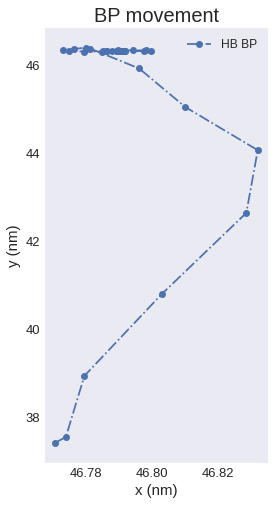

In [9]:
## Similar to Figure 5 in the main paper 
## 

plt.figure(figsize=(4,8))
plt.title("BP movement")
#number represents the number of cells in z-direction
plt.plot(BP_traj_10[:,0], BP_traj_10[:,1], "o--", label = "MM BP 10")
plt.plot(BP_traj_20[:,0], BP_traj_20[:,1], "o--", label = "MM BP 20")
plt.plot(BP_traj_30[:,0], BP_traj_30[:,1], "o--", label = "MM BP 30")
plt.plot(BP_traj_40[:,0], BP_traj_40[:,1], "o--", label = "MM BP 40")
plt.plot(BP_traj_50[:,0], BP_traj_50[:,1], "o--", label = "MM BP 50")
plt.plot(BP_traj_HB[:,0], BP_traj_HB[:,1], "o-.", label = "HB BP")
plt.xlabel("x (nm)")
plt.ylabel("y (nm)")
plt.savefig("Figures/Fig_5_track_BP.svg", dpi=400, bbox_inches="tight")
plt.legend()
plt.show()